# Neural Networks

En esta ocasion, unos expertos en arroz nos han pedido que con los datos  [Rice (Cammeo and Osmancik)](hthttps://archive.ics.uci.edu/dataset/545/rice+cammeo+and+osmanciktps://) hagamos un estudio. En este estudio tenemos dos tipos de arroz y el objetivo es aprender a diferenciar uno del otro para clasificar bien nuevos arroces.

## Procesamiento de datos

### Lectura de datos

Lo primero que tenemos que hacer es importar las librerias que usaremos y leer los datos, que podemos hacerlo accediendo directamente al repositorio.

In [ ]:
pip install ucimlrepo

In [ ]:
from ucimlrepo import fetch_ucirepo
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, RobustScaler,StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from scipy.stats import uniform
from scipy import stats
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.inspection import permutation_importance

In [ ]:
# Cargamos el dataset
df = fetch_ucirepo(id=545)

# Los pasamos a pandas dataframes
X = df.data.features
y = df.data.targets

print(X.shape[0]) #número de ejemplos

# Vemos los datos
X[:10]


3810


,Area,Perimeter,Major_Axis_Length,Minor_Axis_Length,Eccentricity,Convex_Area,Extent
0,15231,525.578979,229.749878,85.093788,0.928882,15617,0.572896
1,14656,494.311005,206.020065,91.730972,0.895405,15072,0.615436
2,14634,501.122009,214.106781,87.768288,0.912118,14954,0.693259
3,13176,458.342987,193.337387,87.448395,0.891861,13368,0.640669
4,14688,507.166992,211.743378,89.312454,0.906691,15262,0.646024
5,13479,477.015991,200.053055,86.650291,0.901328,13786,0.657897
6,15757,509.281006,207.296677,98.336136,0.880323,16150,0.589708
7,16405,526.570007,221.612518,95.436707,0.902521,16837,0.658888
8,14534,483.640991,196.650818,95.050682,0.875429,14932,0.649651
9,13485,471.570007,198.272644,87.727287,0.896789,13734,0.572320


In [ ]:
y[:10]

,Class
0,Cammeo
1,Cammeo
2,Cammeo
3,Cammeo
4,Cammeo
5,Cammeo
6,Cammeo
7,Cammeo
8,Cammeo
9,Cammeo


### Estudio descriptivo

In [ ]:
print(X.info(),'\n')
print(y.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3810 entries, 0 to 3809
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Area               3810 non-null   int64  
 1   Perimeter          3810 non-null   float64
 2   Major_Axis_Length  3810 non-null   float64
 3   Minor_Axis_Length  3810 non-null   float64
 4   Eccentricity       3810 non-null   float64
 5   Convex_Area        3810 non-null   int64  
 6   Extent             3810 non-null   float64
dtypes: float64(5), int64(2)
memory usage: 208.5 KB
None 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3810 entries, 0 to 3809
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Class   3810 non-null   object
dtypes: object(1)
memory usage: 29.9+ KB
None


Vemos que no hay valores perdidos (NA's). Pasamos a ver un resumen estadístico de los datos

In [ ]:
X.describe()

,Area,Perimeter,Major_Axis_Length,Minor_Axis_Length,Eccentricity,Convex_Area,Extent
count,3810.000000,3810.000000,3810.000000,3810.000000,3810.000000,3810.000000,3810.000000
mean,12667.727559,454.239180,188.776222,86.313750,0.886871,12952.496850,0.661934
std,1732.367706,35.597081,17.448679,5.729817,0.020818,1776.972042,0.077239
min,7551.000000,359.100006,145.264465,59.532406,0.777233,7723.000000,0.497413
25%,11370.500000,426.144752,174.353855,82.731695,0.872402,11626.250000,0.598862
50%,12421.500000,448.852493,185.810059,86.434647,0.889050,12706.500000,0.645361
75%,13950.000000,483.683746,203.550438,90.143677,0.902588,14284.000000,0.726562
max,18913.000000,548.445984,239.010498,107.542450,0.948007,19099.000000,0.861050


Aqui podemos estudiar varias cosas. Si el maximo se acerca al cuartil del 75%, no hay outliers. En cambio si el máximo estuviera muy distante del cuartil 75% esto podría indicar la presencia de outliers. El mismo razonamiento lo podemos hacer con el mínimo y el cuartil del 25%, por ejemplo vemos que el mínimo en *Minor_Axis_Length* es mucho menor que el cuartil del 25%, lo mismo pasa con *Eccentricity*.

Por otro lado, si la media es similar a la mediana podría ser un indicativo de que la variable sigue una distribución normal como podría ser el caso del área por ejemplo.

Es evidente que la escala de los datos es muy distinta (en área los datos son miles y en eccentrity no llegan al 1) por lo que tendremos que estandarizar luego, esto es tipificar para que cada variable predictora siga aproximadamente una distribucion aleatoria normal de media 0 y varianza 1.

In [ ]:
y.value_counts()

,count
Class,
Osmancik,2180
Cammeo,1630


In [ ]:
print("Porcentaje de Osmancik {:.2f}".format(y.value_counts().iloc[0]/X.shape[0]))
print("Porcentaje de Cammeo {:.2f}".format(1 - (y.value_counts().iloc[0]/X.shape[0])) )

Porcentaje de Osmancik 0.57
Porcentaje de Cammeo 0.43


Vemos con esto que las clases están balanceadas, aprovechamos también para codificar la variable de clasificación para que sean 0 y 1 (más cómodo luego para separar por colores por ejemplo). Usamos `Label Encoder` de la librería `scikit-learn`.





In [ ]:
le = LabelEncoder()
y_encoded = le.fit_transform(y.values.ravel())

print(y_encoded)
print("Clases:", le.classes_)
#Cammeo es la clase 0 y Osmancik es la clase 1


[0 0 0 ... 1 1 1]
Clases: ['Cammeo' 'Osmancik']


### Representación de los datos



Dibujamos un histograma de las variables predictoras, si tienen "mucha cola" podría ser un indicativo de outliers. También así nos hacemos una idea de si las variables siguien una distribución normal o no.

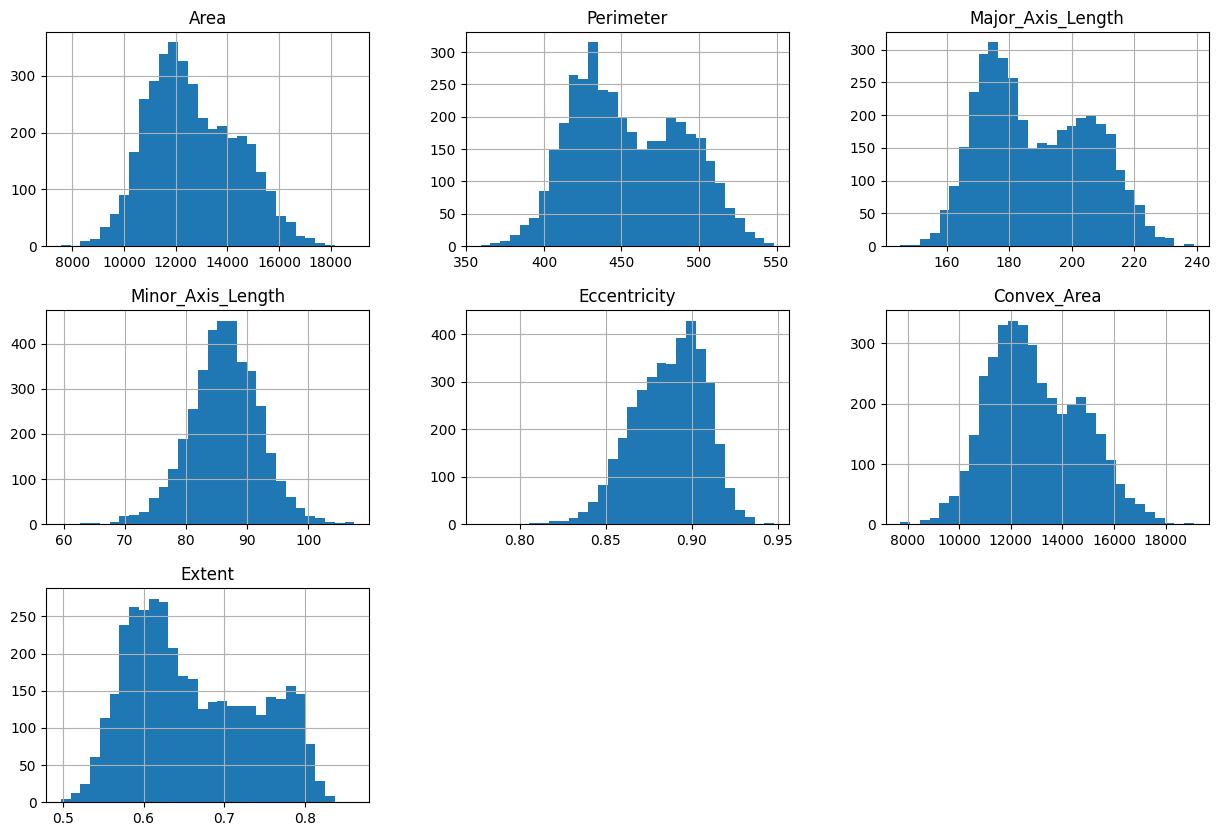

In [ ]:

X.hist(bins=30, figsize=(15, 10))
plt.show()

Vemos que por ejemplo *Eccentrity* está muy descentrada y, en general, parecen seguir una distribución normal.

Otra forma de ver los *ouliers* es mediante los diagrama de tipo *boxplot* y así vemos cuantos elementos se salen de las cajas.

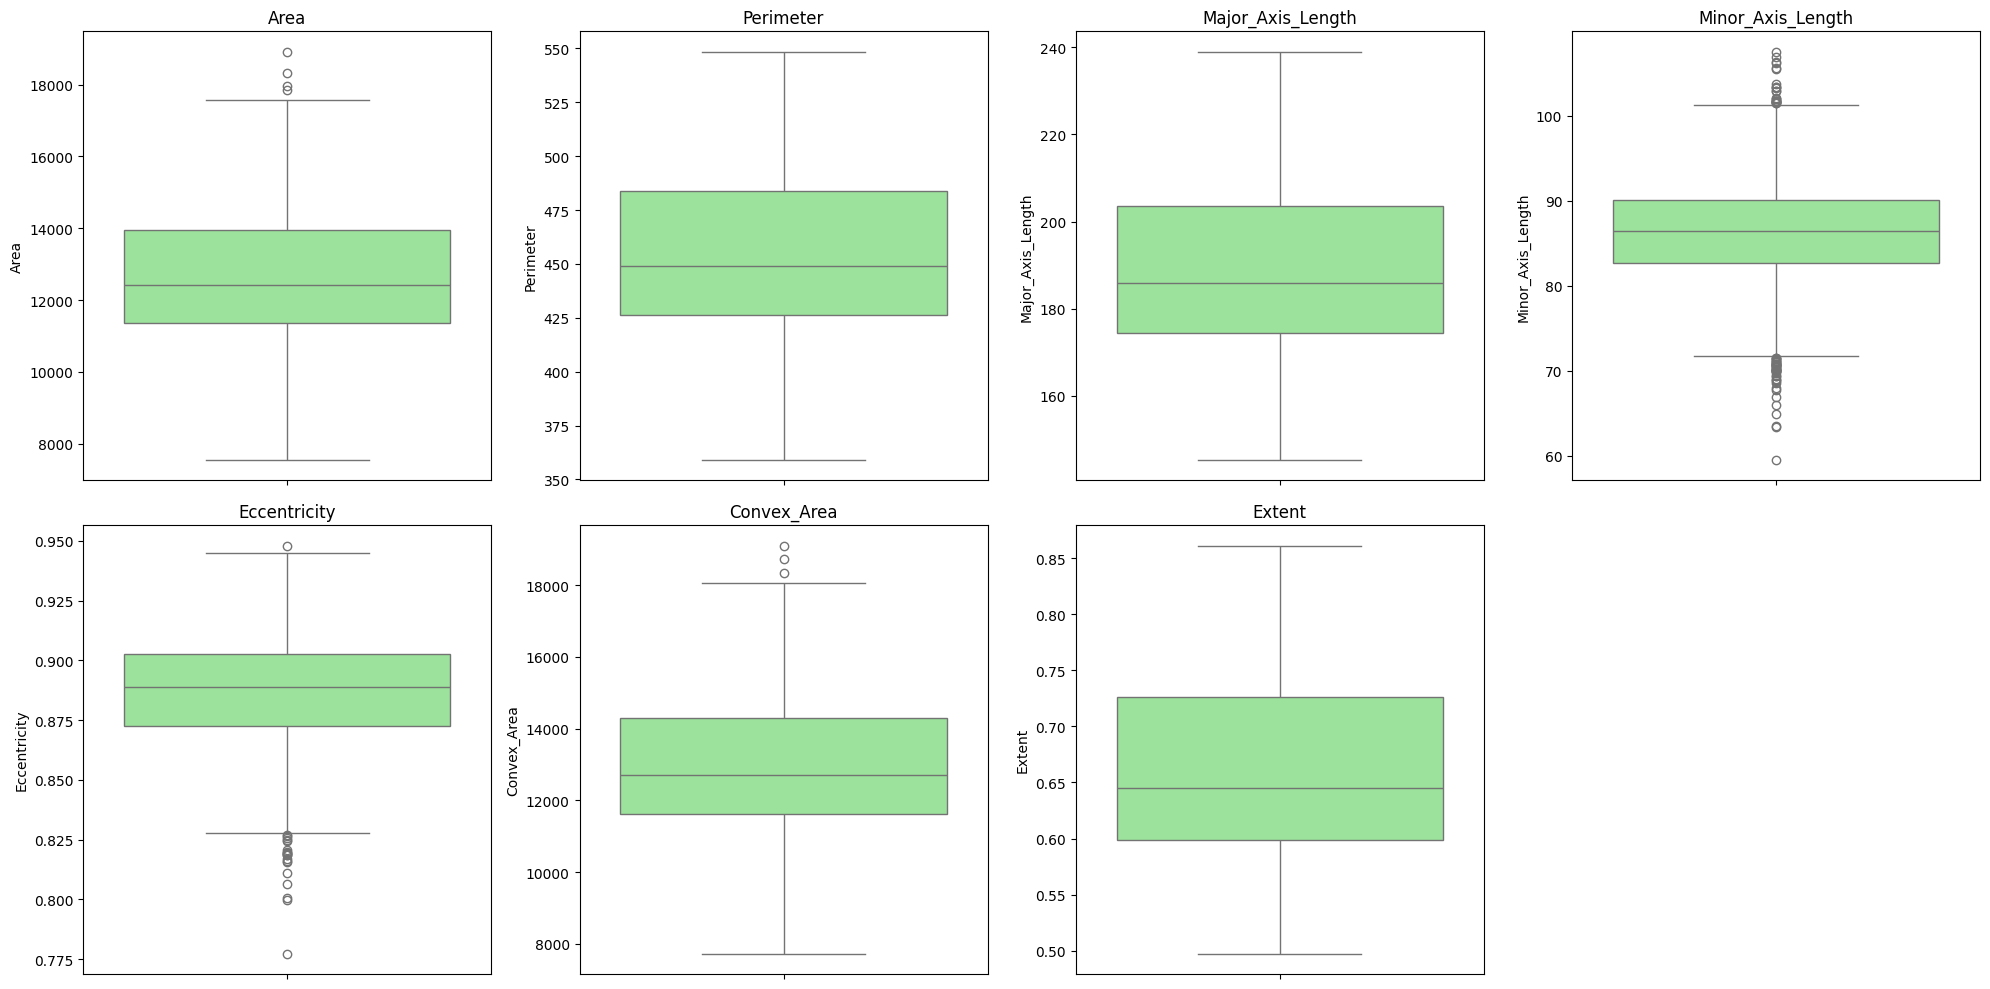

In [ ]:
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(20, 10))
axes = axes.flatten()

for i, col in enumerate(X.columns):
    sns.boxplot(y=X[col], ax=axes[i], color='lightgreen')

    axes[i].set_title(col)

fig.delaxes(axes[7])
plt.tight_layout()
plt.show()

Vemos que por ejemplo en *Minor_Axis_Length* hay muchos que se salen de la caja tanto por abajo como por arriba, más que outliers quizá esto es indicativo de distinción de clases. En cambio en *Eccentricity* si que parece haber un único outlier por arriba y otro por abajo (los puntos que están por debajo muy juntos podría ser distinción de clases también)

Vamos a calular los *z_scores* como en la práctica de clase para elíminar los valores más atípicos

In [ ]:
z_scores = np.abs(stats.zscore(X))

# Fijamos un umbral y eliminamos los ejemplos que tengan un valor que lo superen
umbral = 3

X_nuevo = X[(z_scores < umbral).all(axis=1)]
y_nuevo= y[(z_scores < umbral).all(axis=1)]
y_nuevo_encoded= y_encoded[(z_scores < umbral).all(axis=1)]



In [ ]:
print('Tamaño de la matriz de datos original:', X.shape)
print('Tamaño de la nueva matriz de datos   :', X_nuevo.shape)
print('    * Hemos eliminado', X.shape[0] - X_nuevo.shape[0], 'instancias')

Tamaño de la matriz de datos original: (3810, 7)
Tamaño de la nueva matriz de datos   : (3776, 7)
    * Hemos eliminado 34 instancias


Con algunas instancias eliminadas, pasamos otra vez a ver los *boxplots*

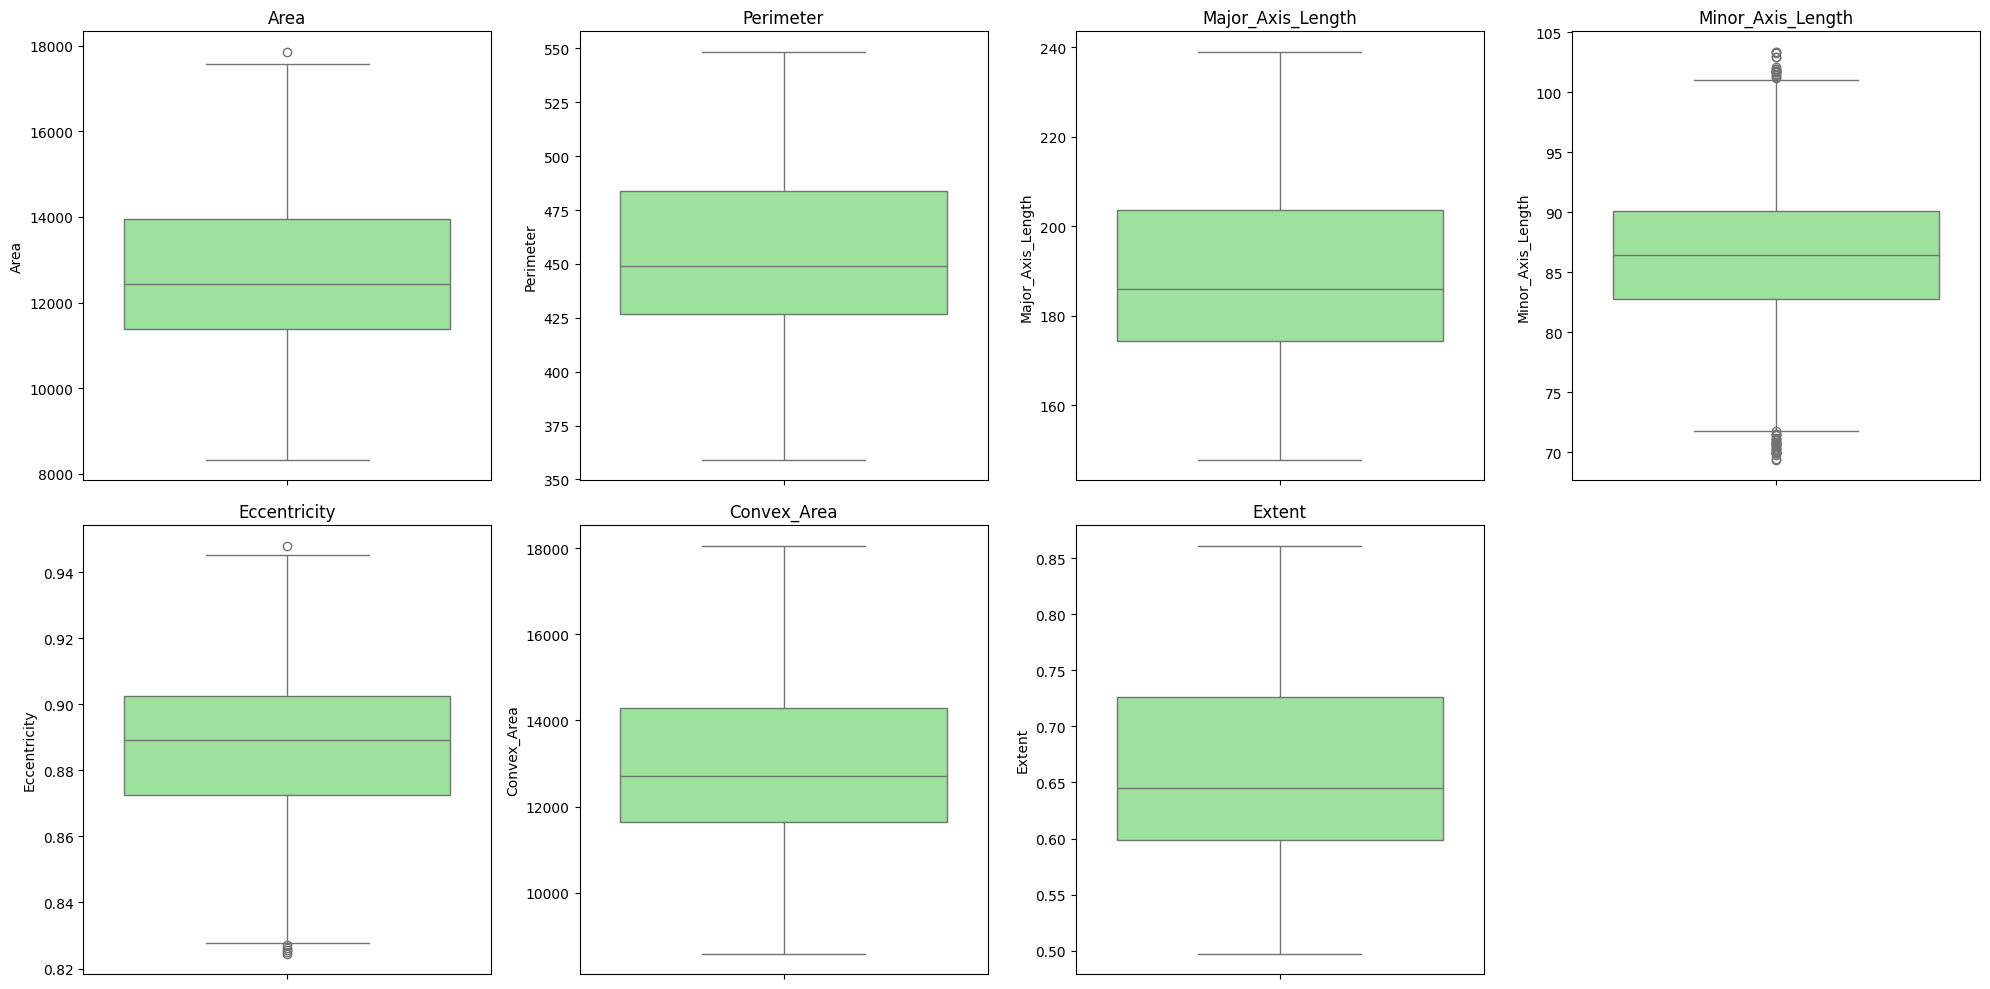

In [ ]:
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(20, 10))
axes = axes.flatten()

for i, col in enumerate(X.columns):
    sns.boxplot(y=X_nuevo[col], ax=axes[i], color='lightgreen')

    axes[i].set_title(col)

fig.delaxes(axes[7])
plt.tight_layout()
plt.show()

Vemos que se han eliminado os outliers superiores de *Convex_Area* y el extremo inferior de *Eccentricitty* por ejemplo

Separamos ahora los boxplots según su clasificación

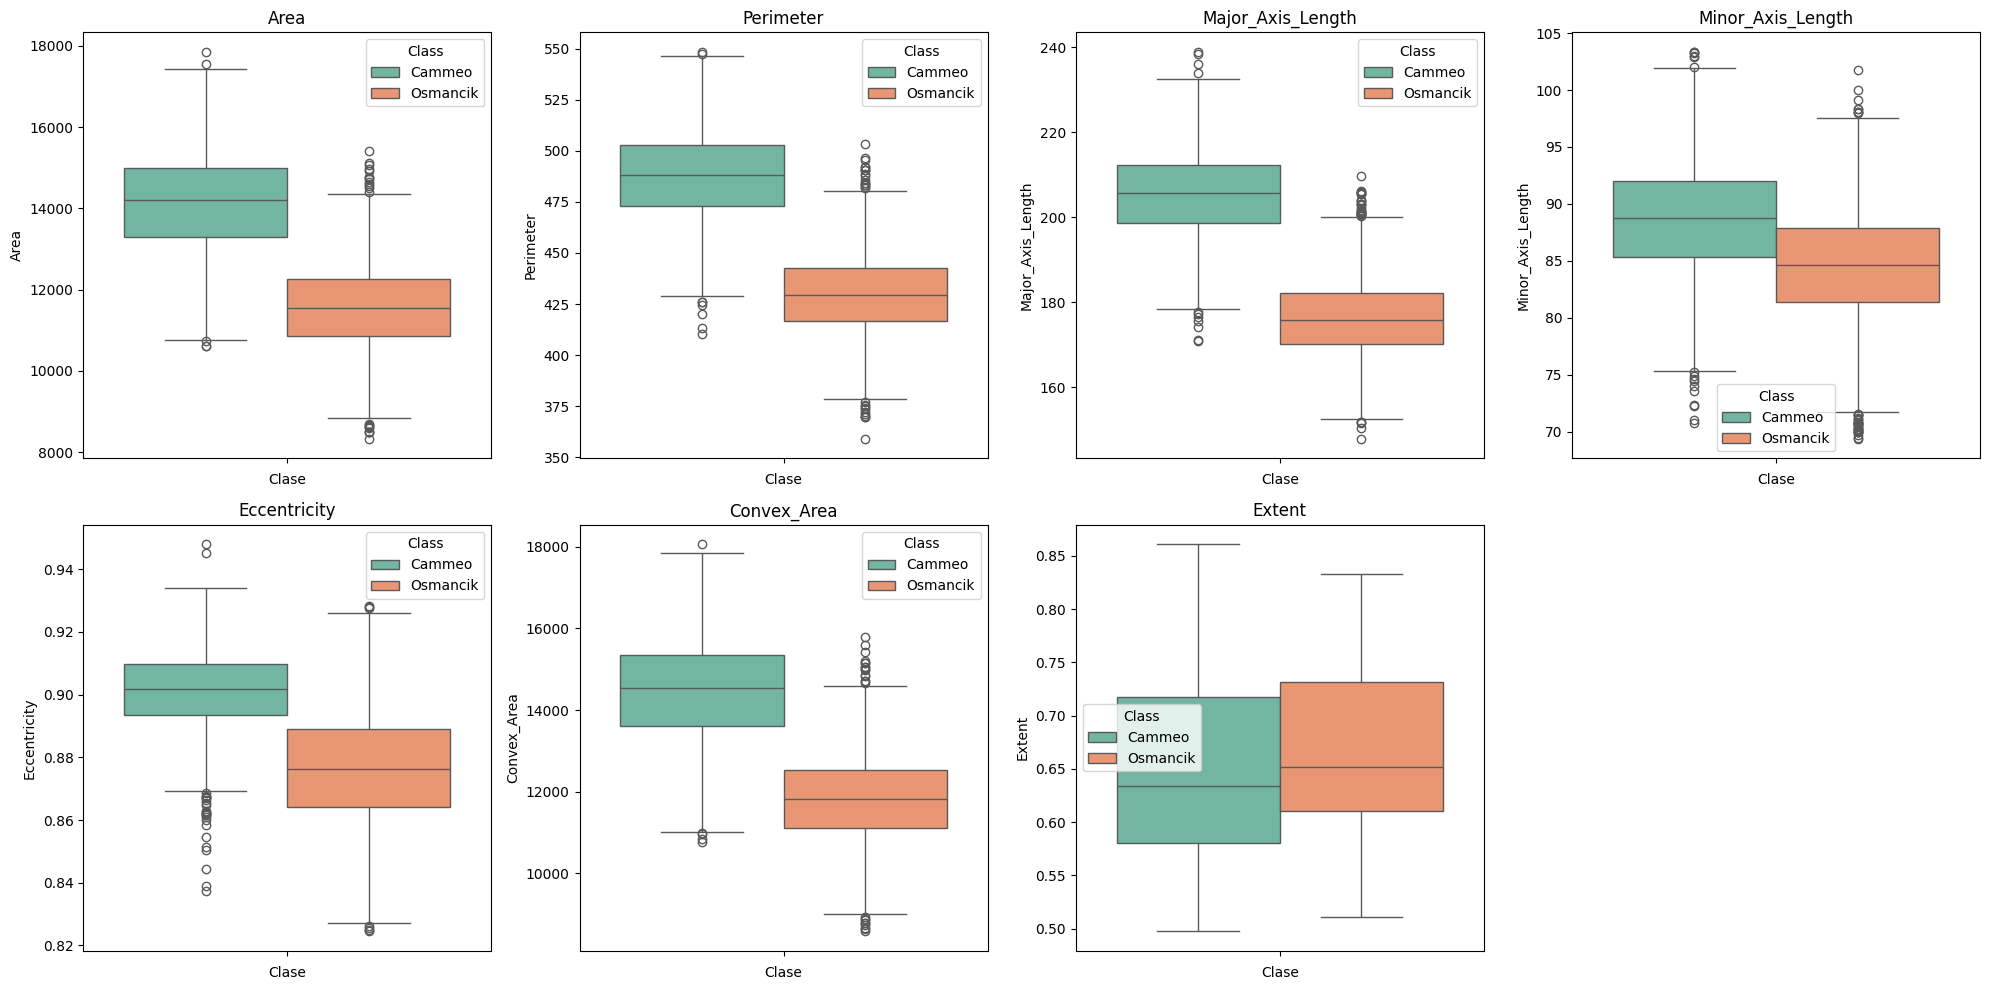

In [ ]:

fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(20, 10))


axes = axes.flatten()


for i, col_name in enumerate(X.columns):
    sns.boxplot(
        hue=y_nuevo.iloc[:, 0],
        y=X_nuevo[col_name],
        ax=axes[i],
        palette="Set2"
    )
    axes[i].set_title(col_name)
    axes[i].set_xlabel("Clase")

#Borramos el gráfico número 8 (el último) porque está vacío (tienes 7 variables, sobran huecos)
fig.delaxes(axes[7])


plt.tight_layout()
plt.show()

Vemos que las clases parecen bastante diferenciables, ya que los valores se concentran en sitios distintos para cada clase. Vemos esto también usando la *scatter matrix*

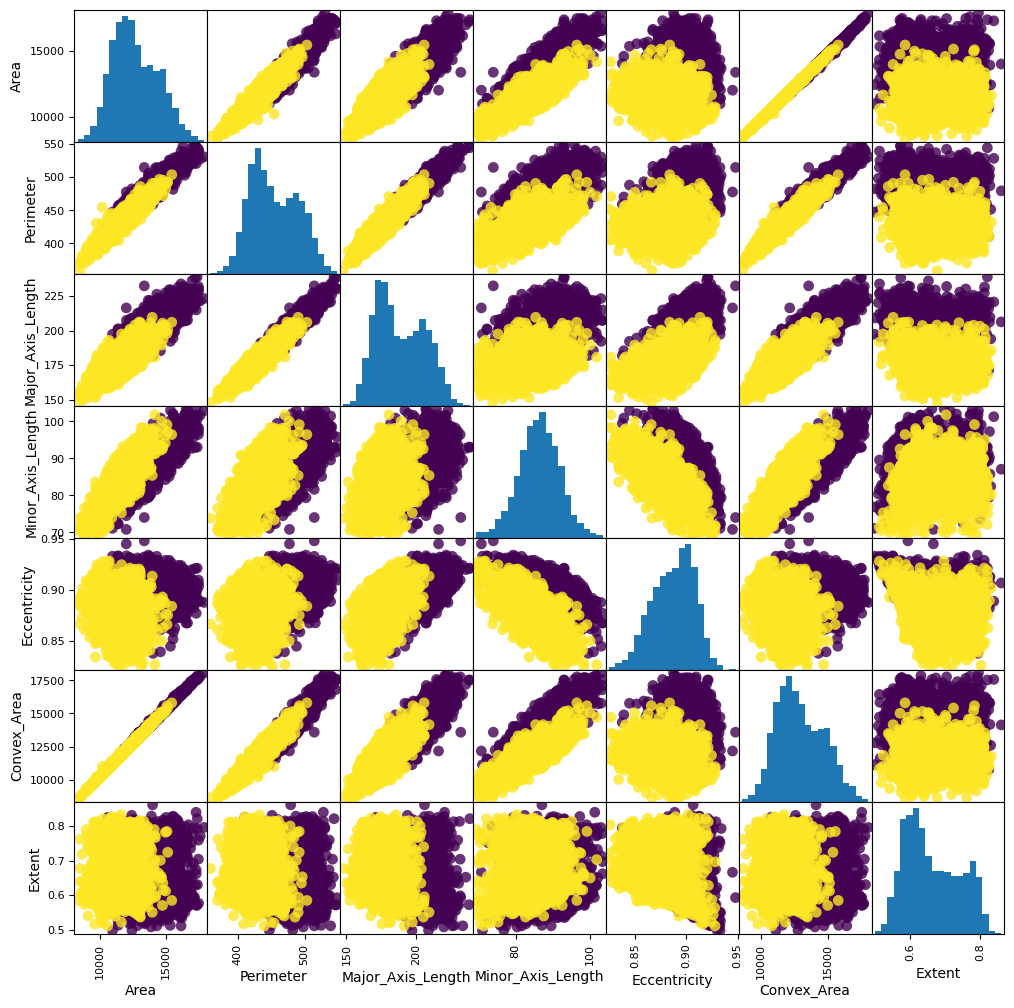

In [ ]:
sp = pd.plotting.scatter_matrix(X_nuevo, c=y_nuevo_encoded, figsize=(12, 12), marker='o',
                                 hist_kwds={'bins': 20}, s=60, alpha=.8)

Vemos que en los valores más extremos parecen separarse por colores mientras que en los valores más centricos hay de los dos tipos. Igualmente luego haremos una representación reduciendo los datos a una menor dimensión para ver la separabilidad de los mismos. Lo que nos llama la atención es que la gráfica de *Area* y *Convex_Area* es practicamente lineal. Esto se debe a que seguro que esas variables tienen mucha correlación

Pasamos entonces a ver la correlación de las variables para ver si podemos confirmar nuestra hipótesis.

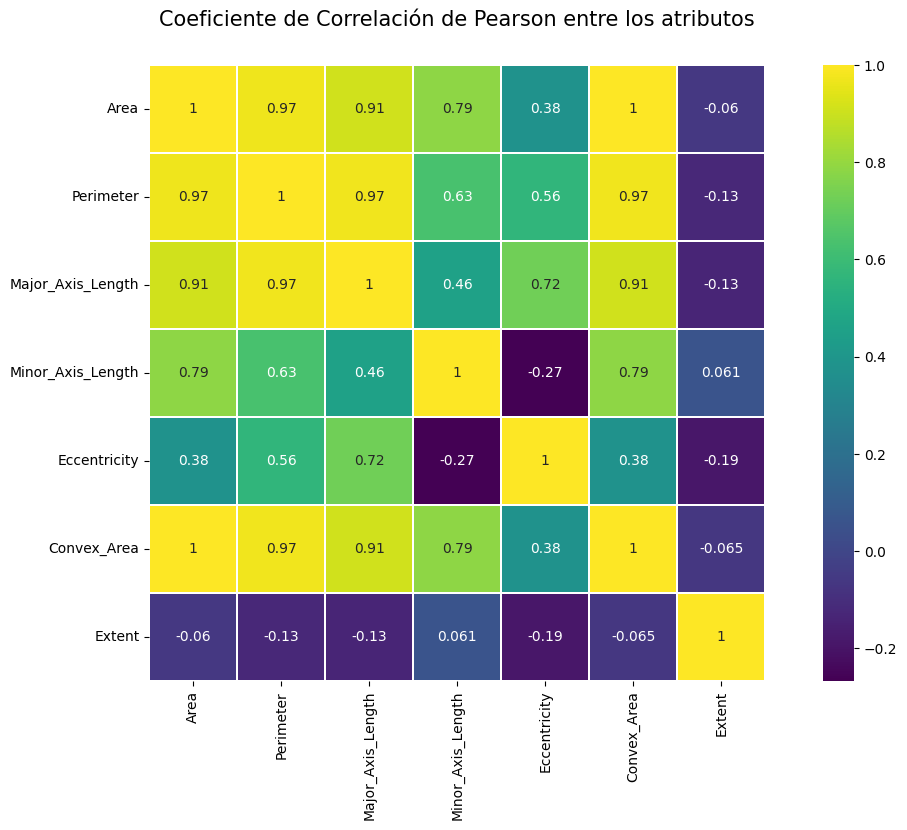

In [ ]:
plt.figure(figsize=(15,8))
plt.title('Coeficiente de Correlación de Pearson entre los atributos', y=1.05, size=15)
sns.heatmap(X_nuevo.corr(),linewidths=0.1,vmax=1.0,
            square=True, cmap='viridis', linecolor='white', annot=True)
plt.show()

Vemos que la variable más independiente es *Eccentricity*. Y algo que obviamente también nos llama la atención es que tenemos 4 variables que son prácticamente iguales como ya veníamos adelantando, a este efecto se le llama **multicolinealidad**. *Area* y *Convex_Area* tienen una correlación perfecta por lo que es redundante y deberíamos de quitar una. Por otro lado perimeter también aporta exactamente la misma información que *Major_Axis_Length*, que *Area* y que *Convex_Area* y aunque *Area* y *Major_Axis_Length* son muy parecidas entre sí (correlación de 0.91) no son exactamente iguales. Evidentemente guardan relación (pues a mayor longitud de eje mayor área) pero no son iguales, quizás esa diferencia es la diferencia entre las dos clases por ejemplo. Podríamos ver esto haciendo una regresión lineal pero viendo el nivel de correlación no es necesario entrar en más detalle.

Quitaremos entonces del estudio las variables *Convex_Area* y *Perimeter*.

Es importante hacer este tipo de cambios para obtener los mejores resultados posibles, que a fin de cuentas es lo que buscamos en este estudio, ya que



*   Aumenta la simpleza del modelo a nivel humano: Es mejor tener un modelo de 5 variables a uno de 7 a nivel humano ya que por ejemplo puede ser dinero que nos ahorremos ya que no necesitamos medir estás características o tiempo que nos ahorremos.

*   Evita el sobreajuste: Pasandole a la red variables "copiadas" puede facilitar que la red memorice ruido.

* Aumenta la simpleza del modelo a nivel computacional: Al pasarle menos datos a la red neuronal que usaremos luego, liberamos cálculo que gastaría en procesar información repetida. Esto puede parecer tontería en un modelo con pocos ejemplos, pero en un modelo muy grande esta diferencia es muy importante.




Eliminamos ahora entonces las variables

In [ ]:


cols_to_drop = ['Convex_Area', 'Perimeter']


X_limpio = X_nuevo.drop(columns=cols_to_drop)

print(f"Dimensiones originales: {X_nuevo.shape}")
print(f"Dimensiones nuevas: {X_limpio.shape}")


Dimensiones originales: (3776, 7)
Dimensiones nuevas: (3776, 5)


Ahora nuestras variables están en 5 dimensiones, pero las pasamos a 2D para poder pintarlas y ver si son separables. Se podrían pasar también a 3D pero como solo tenemos 5 variables, con 2D seguramente será suficiente además de que visualizamos mejor un plano que el espacio. Lo haremos con  TSNE.

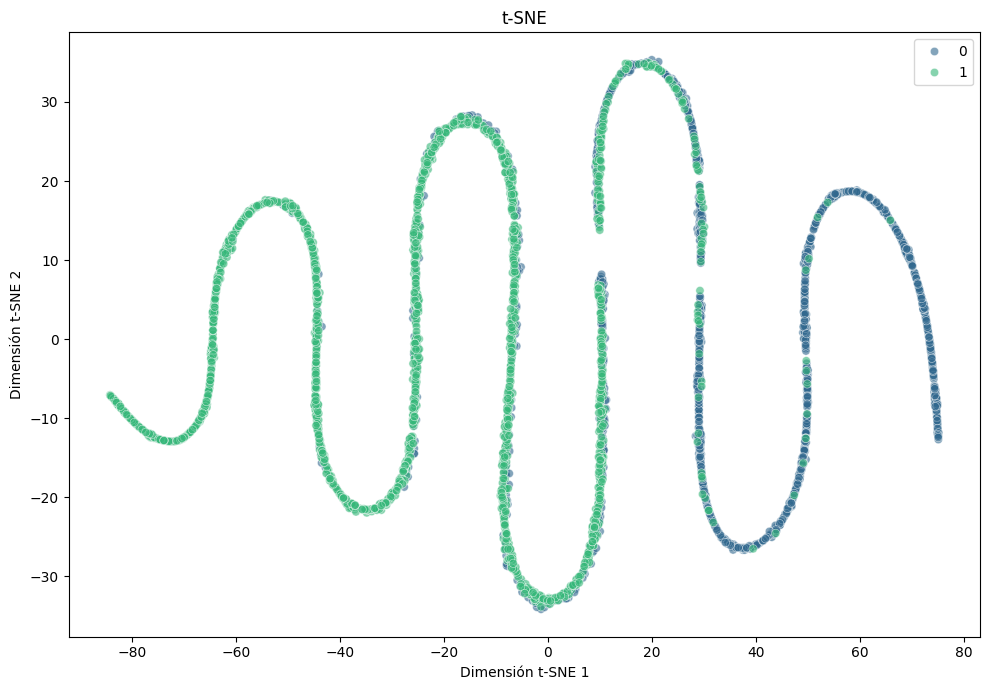

In [ ]:
fig, ax = plt.subplots(figsize=(10, 7))


tsne = TSNE(n_components=2, perplexity=50, init='pca', learning_rate='auto', random_state=42)
X_tsne = tsne.fit_transform(X_limpio)


sns.scatterplot(
    x=X_tsne[:, 0], y=X_tsne[:, 1],
    hue=y_nuevo_encoded,
    palette='viridis',
    alpha=0.6,
    ax=ax
)


ax.set_title('t-SNE')
ax.set_xlabel('Dimensión t-SNE 1')
ax.set_ylabel('Dimensión t-SNE 2')

plt.tight_layout()
plt.show()

Vemos que las clases están bien diferenciadas así que seguramente nuestro modelo funcione bien.

## Entrenamiento del modelo

### Conjuntos Train y Test. Estandarización de los datos

Como adelantamos antes, vamos a estandarizar o normalizar los datos, es decir, si asumimos que las variables son normales vamos a convertirlas todas en $\mathcal{N}(0,1)$. Esto se hace para que todas las variables tengan la misma escala y así se traten todas en igualdad de condiciones.

Hay dos formas de estandarizar usando la libreria `scikit-learn`.



*   StandarScaler. Es la tipificación normal y corriente, restar la media y dividir entre la desviación típica

*   RobustScaler. Esta se usa cuando no se han tratado los outliers y estos se quieren mantener. Es más robusta respecto a los outliers porque usa la mediana en vez de la media y el rango intercuartílico.

Nosotros usaremos `StandarScaler` pues hemos quitado algunos outliers.



Primero separaremos en los conjuntos test y train y luego normalizaremos. Esto se debe a que queremos que los datos test sean completamente nuevos ante nuestro modelo, pero si normalizamos todos los datos primero, estaremos usando para calcular la media y la desviación típica precisamente esos datos que queremos que sean nuevos para nosotros así que ya tendremos un mínimo de información sobre ellos. Lo ideal es entonces separar los conjuntos y luego normalizar los datos de train, y luego los test normalizarlos usando la normalización de los train.

In [ ]:
# Dividimos los conjuntos
X_train, X_test, y_train, y_test = train_test_split(
    X_limpio, y_nuevo_encoded, test_size=0.2, random_state=42)



scaler = StandardScaler()
scaler.fit(X_train)

# Transformamos ambos conjuntos con la normalizacion de train
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_scaled=scaler.transform(X_limpio)


print(f"Tamaño de entrenamiento: {X_train_scaled.shape}")
print(f"Tamaño de prueba: {X_test_scaled.shape}")

Tamaño de entrenamiento: (3020, 5)
Tamaño de prueba: (756, 5)


### Red neuronal

Ahora con todo preparado pasamos a entrenar nuestra red neruonal

In [ ]:
mlp = MLPClassifier(solver="lbfgs",max_iter=700,random_state=42,hidden_layer_sizes=(10,2,))
mlp.fit(X_train_scaled, y_train)


MLPClassifier(hidden_layer_sizes=(10, 2), max_iter=700, random_state=42,
              solver='lbfgs')

Usamos el solver `lbfgs` pues nuestro dataset es pequeño y tiene poco ruido, para dataset grandes con ruido es mejor usar `adam`

In [ ]:
print("Rendimiento en entenamiento: {:.2f}".format(mlp.score(X_train_scaled, y_train)))
print("Rendimiento en el conjunto de prueba: {:.2f}".format(mlp.score(X_test_scaled, y_test)))
print("Rendimiento en el conjunto total: {:.2f}".format(mlp.score(X_scaled, y_nuevo_encoded)))

Rendimiento en entenamiento: 0.93
Rendimiento en el conjunto de prueba: 0.92
Rendimiento en el conjunto total: 0.93


Vemos que hemos obtenido un 92% de éxito, pero ¿es esta la mejor red que podemos encontrar?

### Busqueda de la mejor red

Queremos buscar una red que tenga el máximo rendimiento posible pero que sea lo más simple posible para que así se pueda ahorrar computacionalmente. Para tener una orientación usamos una busqueda aleatoria (`RandomizedSearchCV`) que usa validación cruzada

In [ ]:

param_dist = {
    'hidden_layer_sizes': [
        (4,), (6,), (8,),
        (6, 2), (8, 2), (10, 2),
        (12,4),(10,5),(16, 8), (32, 16),
        (50, 25), (100,)
    ],
    'activation': ['tanh', 'relu','logistic']
}


mlp = MLPClassifier(solver='lbfgs', max_iter=1000, random_state=42)


random_search = RandomizedSearchCV(
    mlp,
    param_distributions=param_dist,
    n_iter=20,
    cv=5,
    n_jobs=-1,
    verbose=1,
    random_state=42
)


random_search.fit(X_train_scaled, y_train)


# Convertimos los resultados a una tabla para leerlos bien
results_df = pd.DataFrame(random_search.cv_results_)

# Seleccionamos las columnas que nos interesan
cols = ['param_hidden_layer_sizes', 'param_activation', 'mean_test_score', 'rank_test_score']
results_df = results_df[cols].sort_values('rank_test_score')

print("\nP 5 MEJORES MODELOS ENCONTRADOS:")
print(results_df.head(5))

Fitting 5 folds for each of 20 candidates, totalling 100 fits

P 5 MEJORES MODELOS ENCONTRADOS:
   param_hidden_layer_sizes param_activation  mean_test_score  rank_test_score
1                      (6,)             relu         0.927483                1
15                   (6, 2)             relu         0.927152                2
12                     (4,)             tanh         0.925828                3
4                    (8, 2)             relu         0.925497                4
7                      (4,)             relu         0.924503                5


Vemos que todos los modelos dan un resultado similar así que nos quedaremos con uno de una sola capa para que el modelo sea lo más simple posible.

Exploramos a continuación de forma exahustiva, con una sola capa los rendimientos con las diferentes funciones de activación

In [ ]:
for i in range(2,10):
  for j in ['relu','tanh','logistic']:
    mlp_best = MLPClassifier(solver="lbfgs",activation=j,max_iter=1000,random_state=42,hidden_layer_sizes=(i,))
    mlp_best.fit(X_train_scaled, y_train)
    print("Número de neuronas :",i, "  Función de activación : ",j)
    print("Rendimiento en entenamiento: {:.3f}".format(mlp_best.score(X_train_scaled, y_train)))
    print("Rendimiento en el conjunto de prueba: {:.3f}".format(mlp_best.score(X_test_scaled, y_test)))
    print("Rendimiento en el conjunto total: {:.3f}".format(mlp_best.score(X_scaled, y_nuevo_encoded)))
    print("\n \n")


Número de neuronas : 2   Función de activación :  relu
Rendimiento en entenamiento: 0.928
Rendimiento en el conjunto de prueba: 0.935
Rendimiento en el conjunto total: 0.929

 

Número de neuronas : 2   Función de activación :  tanh
Rendimiento en entenamiento: 0.926
Rendimiento en el conjunto de prueba: 0.929
Rendimiento en el conjunto total: 0.927

 

Número de neuronas : 2   Función de activación :  logistic
Rendimiento en entenamiento: 0.927
Rendimiento en el conjunto de prueba: 0.931
Rendimiento en el conjunto total: 0.928

 

Número de neuronas : 3   Función de activación :  relu
Rendimiento en entenamiento: 0.929
Rendimiento en el conjunto de prueba: 0.929
Rendimiento en el conjunto total: 0.929

 

Número de neuronas : 3   Función de activación :  tanh
Rendimiento en entenamiento: 0.929
Rendimiento en el conjunto de prueba: 0.930
Rendimiento en el conjunto total: 0.929

 

Número de neuronas : 3   Función de activación :  logistic
Rendimiento en entenamiento: 0.929
Rendimiento 

/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


Número de neuronas : 7   Función de activación :  tanh
Rendimiento en entenamiento: 0.931
Rendimiento en el conjunto de prueba: 0.922
Rendimiento en el conjunto total: 0.929

 

Número de neuronas : 7   Función de activación :  logistic
Rendimiento en entenamiento: 0.930
Rendimiento en el conjunto de prueba: 0.927
Rendimiento en el conjunto total: 0.930

 

Número de neuronas : 8   Función de activación :  relu
Rendimiento en entenamiento: 0.932
Rendimiento en el conjunto de prueba: 0.926
Rendimiento en el conjunto total: 0.931

 



/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


Número de neuronas : 8   Función de activación :  tanh
Rendimiento en entenamiento: 0.929
Rendimiento en el conjunto de prueba: 0.913
Rendimiento en el conjunto total: 0.926

 

Número de neuronas : 8   Función de activación :  logistic
Rendimiento en entenamiento: 0.929
Rendimiento en el conjunto de prueba: 0.914
Rendimiento en el conjunto total: 0.926

 

Número de neuronas : 9   Función de activación :  relu
Rendimiento en entenamiento: 0.931
Rendimiento en el conjunto de prueba: 0.915
Rendimiento en el conjunto total: 0.928

 



/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


Número de neuronas : 9   Función de activación :  tanh
Rendimiento en entenamiento: 0.932
Rendimiento en el conjunto de prueba: 0.925
Rendimiento en el conjunto total: 0.930

 

Número de neuronas : 9   Función de activación :  logistic
Rendimiento en entenamiento: 0.932
Rendimiento en el conjunto de prueba: 0.923
Rendimiento en el conjunto total: 0.930

 



Vemos que todas tienen un rendimiento muy similar e incluso podría parecer que al meter más neuronas en la capa oculta el rendimiento del modelo baja debido al sobreajuste. Por tanto nos quedamos con la más simple,es decir la que solo tiene 2 neuronas, ya que no tiene sentido considerar un modelo tan complejo pudiendo optar por una arquitectura más sencilla e igual o mejor rendimiento. Como función de activación, nos quedamos con la **ReLu** por ejemplo. **Tanh** es la tangente hiperbólica y **logistic** es la sigmoide, vista en clase. Como el modelo es muy simple y los datos se separan bien, la función de activación no presenta grandes diferencias así que podemos escoger la que queramos.

In [ ]:
mlp_best = MLPClassifier(solver="lbfgs",activation='relu',max_iter=1000,random_state=42,hidden_layer_sizes=(2,))
mlp_best.fit(X_train_scaled, y_train)
print("Rendimiento en entenamiento: {:.3f}".format(mlp_best.score(X_train_scaled, y_train)))
print("Rendimiento en el conjunto de prueba: {:.3f}".format(mlp_best.score(X_test_scaled, y_test)))
print("Rendimiento en el conjunto total: {:.3f}".format(mlp_best.score(X_scaled, y_nuevo_encoded)))

Rendimiento en entenamiento: 0.928
Rendimiento en el conjunto de prueba: 0.935
Rendimiento en el conjunto total: 0.929


### Matriz de confusión y reporte de clasificación

Ahora podemos hacer varias cosas, por ejemplo mirar la matriz de confusion y la curva ROC y el AUC. Recordamos que el área bajo la curva ROC (AUC) era una medida de bondad de ajuste, cuánto más cerca de 1 mejor.

La curva ROC representaba la sensibilidad (verdaderos positivos) contra la tasa de falsos positivos (1 - especificidad).

Vemos la matriz de confusión

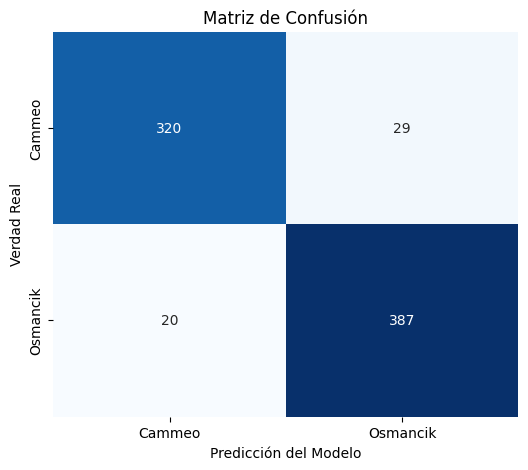


--- REPORTE DE CLASIFICACIÓN ---
              precision    recall  f1-score   support

      Cammeo       0.94      0.92      0.93       349
    Osmancik       0.93      0.95      0.94       407

    accuracy                           0.94       756
   macro avg       0.94      0.93      0.93       756
weighted avg       0.94      0.94      0.94       756



In [ ]:

y_pred = mlp_best.predict(X_test_scaled)

# Generamos la Matriz de Confusión
cm = confusion_matrix(y_test, y_pred)

#  Visualización
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Cammeo', 'Osmancik'],
            yticklabels=['Cammeo', 'Osmancik'])

plt.xlabel('Predicción del Modelo')
plt.ylabel('Verdad Real')
plt.title(f'Matriz de Confusión')
plt.show()

# Reporte
print("\n--- REPORTE DE CLASIFICACIÓN ---")
print(classification_report(y_test, y_pred, target_names=['Cammeo', 'Osmancik']))

Vemos que el modelo es bueno, para interpretar los número anteriores tenemos que saber que es cada cosa



*   Precisión. Mide el porcentaje de entre todos los clasificados como una clase, cuántos eran de esa clase de verdad.

*   Recall. Mide el porcentaje de los clasificados bien en una clase respecto el total de esa clase que había.

* F1-score. Es la media de las dos anteriores



Este reporte es muy útil más que nada cuando las clases están desbalanceadas pues así se ven de forma individual. En nuestro caso están balanceadas, pero no está de más revisar la clasificación por clase.

### Curva ROC y AUC

Sacamos ahora la curva ROC y el AUC

--- RESULTADO ---
AUC: 0.9774


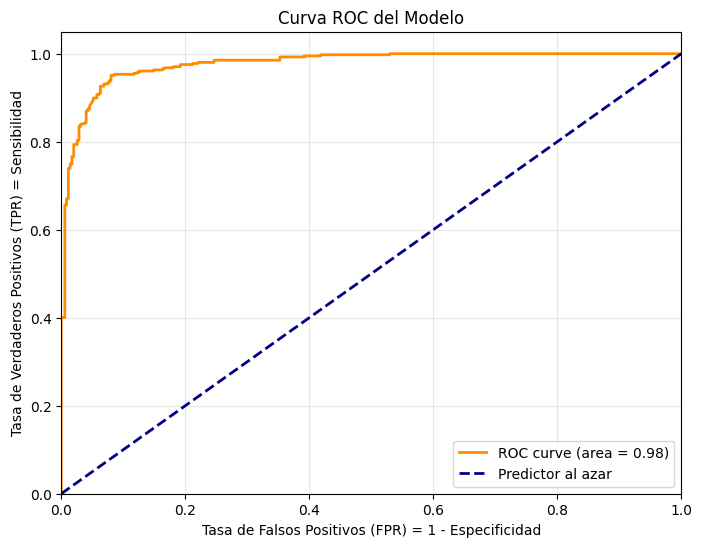

In [ ]:

y_probs = mlp_best.predict_proba(X_test_scaled)[:, 1]

# Calculamos la curva ROC (Falsos Positivos vs Verdaderos Positivos)
fpr, tpr, thresholds = roc_curve(y_test, y_probs)

# Calculamos el AUC
roc_auc = auc(fpr, tpr)
print(f"--- RESULTADO ---")
print(f"AUC: {roc_auc:.4f}")

# Pintamos la gráfica
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Predictor al azar')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de Falsos Positivos (FPR) = 1 - Especificidad')
plt.ylabel('Tasa de Verdaderos Positivos (TPR) = Sensibilidad')
plt.title('Curva ROC del Modelo')
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.show()

Vemos que al AUC está muy próximo a 1, lo que indica que nuestro modelo es bueno

### Importancia de las variables

Al tener una red tan pequeña, con además tan pocas variables quizás podamos introducir algo de explicabilidad aunque el modelo sea de caja negra. Para ello vamos a realizar dos procesos

Lo primero que haremos será permutación. Este proceso consiste en permutar los valores de una variable aleatoriamente y ver cuánto ha bajado el rendimiento. Si el rendimiento sigue igual es que esa variable no importaba, en cambio si decrece es que esa variable era importancia y determinante. Usamos la función `perm_importance` de `scikit-learn`. Hacemos 10 repeticiones para obtener una media

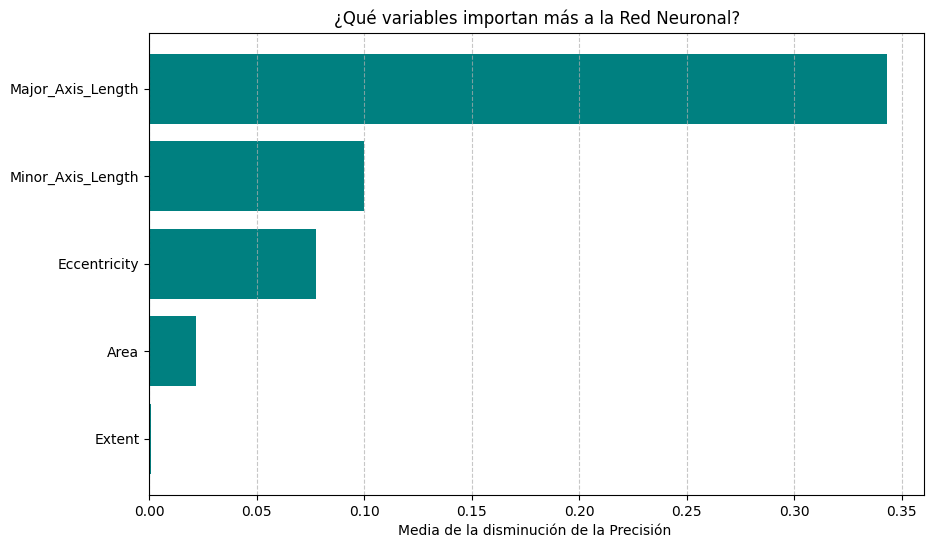

In [ ]:

perm_importance = permutation_importance(mlp_best, X_test_scaled, y_test, n_repeats=10, random_state=42, n_jobs=-1)

feature_names = X_limpio.columns

sorted_idx = perm_importance.importances_mean.argsort()


plt.figure(figsize=(10, 6))
plt.barh(range(len(sorted_idx)), perm_importance.importances_mean[sorted_idx], align='center', color='teal')
plt.yticks(range(len(sorted_idx)), [feature_names[i] for i in sorted_idx])
plt.xlabel("Media de la disminución de la Precisión ")
plt.title("¿Qué variables importan más a la Red Neuronal?")
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()

Como nuestra red es tan simple que solo tiene una capa oculta, también podemos ver los pesos para interpretar la importancia de las variables. Lo que haremos será sumar el valor absoluto de los pesos relacionados con las variables. Si la suma de los valores absolutos de los pesos es muy grande, quiere decir que esa variable es importante

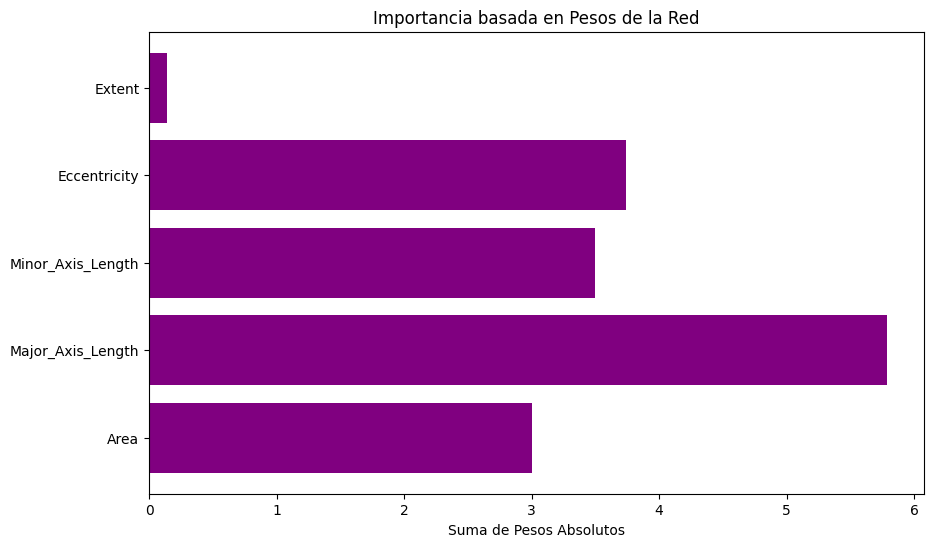

In [ ]:
# Pesos de la primera capa
weights = mlp_best.coefs_[0]



importance_proxies = np.sum(np.abs(weights), axis=1)


plt.figure(figsize=(10, 6))
plt.barh(feature_names, importance_proxies, color='purple')
plt.xlabel("Suma de Pesos Absolutos")
plt.title("Importancia basada en Pesos de la Red")
plt.show()

Vemos en ambos gráficos que la variable más importante es Major_Axis_Length y que la menos importante es Extent. Por lo que lo podemos asumir cierto. Quizás si quisieramos simplificar más todavía la toma de datos podríamos eliminar la variable Extent del estudio, para ello habría que estudiar cuánto rendimiento se pierde sin esa variable y hablar con los expertos en arroz para que tomen la decisión según lo que les interese a ellos, pues al final nosotros somos los que analizamos los datos pero son ellos quienes tienen las decisiones finales.